In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

## Distillation Class

In [2]:
class Distiller(tf.keras.Model):
  def __init__(self, teacher, student):
      super(Distiller, self).__init__()
      
      # Attributs de la classe Distiller
      self.teacher = teacher
      self.student = student
      
  # Compilation du model
  def compile( self, optimizer, metrics, distillation_loss_fn, student_loss_fn, alpha = 0.1, temperature= 20):

    super(Distiller,self).compile(optimizer = optimizer, metrics= metrics )
    # losses
    self.distillation_loss_fn = distillation_loss_fn
    self.student_loss_fn = student_loss_fn

    # Hyperparameters
    self.temperature = temperature
    self.alpha = alpha
  
  # Training Step
  def train_step(self, data):
    # Unpack data
    x, y = data

    # Forward pass of teacher
    teacher_predictions = self.teacher(x, training=False)
    with tf.GradientTape() as tape:
      # student forward
      student_predictions = self.student(x, training= True)

      # Compute losses
      student_loss = self.student_loss_fn(y, student_predictions)
      distillation_loss = self.distillation_loss_fn(
          tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
          tf.nn.softmax(student_predictions / self.temperature, axis=1),
        )

      loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

    # Compute gradients
    trainable_vars = self.student.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)

    # Update weights
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))

    # Update the metrics configured in `compile()`.
    self.compiled_metrics.update_state(y, student_predictions)

    # Return a dict of performance
    results = {m.name: m.result() for m in self.metrics}
    results.update(
        {"student_loss": student_loss, "distillation_loss": distillation_loss}
    )
    return results

  # Test Step
  def test_step(self, data):
    
    # Unpack the data
    x, y = data

    # Compute predictions
    y_prediction = self.student(x, training=False)

    # Calculate the loss
    student_loss = self.student_loss_fn(y, y_prediction)

    # Update the metrics.
    self.compiled_metrics.update_state(y, y_prediction)

    # Return a dict of performance
    results = {m.name: m.result() for m in self.metrics}
    results.update({"student_loss": student_loss})
    return results


## Ploting history fonction

In [3]:
def plot_hist(los1,los2, accur1, accur2):
  plt.figure(figsize= (20,7))
  plt.subplot(121)
  plt.plot(accur1, label='KD Accuracy')
  plt.plot(accur2, label= 'Scratch Accuracy')

  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.grid()
  plt.legend()


  plt.subplot(122)
  plt.plot(los1, label='KD Loss')
  plt.plot(los2,  label= 'Scratch Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  plt.grid()
  plt.legend()
  plt.show()


## Loading and processing Data

In [4]:
# Data loading
(x_train, y_train) , (x_test, y_test)= tf.keras.datasets.mnist.load_data()

# Normalize data
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

print("Dimensions des données")
print("X_train shape: ", x_train.shape)
print("X_test shape: ", x_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

11501568/11490434 [==============================] - 0s 0us/step
Dimensions des données
X_train shape:  (60000, 28, 28)
X_test shape:  (10000, 28, 28)
y_train shape:  (60000,)
y_test shape:  (10000,)


In [5]:
#Padding des images pour correspondre aux données du mobilenet
def im_padding(x_train, x_test, pad = 2):
  x = np.zeros((x_train.shape[0], x_train.shape[1]+2*pad, x_train.shape[1]+ 2*pad ))
  x_t = np.zeros((x_test.shape[0], x_test.shape[1]+2*pad, x_test.shape[1]+ 2*pad ))

  for d in range(len(x)):
    x[d] = np.pad(x_train[d], pad )
    if d < len(x_t):
      x_t[d] = np.pad(x_test[d], pad )

  return x, x_t

#========================================
x_train, x_test = im_padding(x_train, x_test, pad = 2)

x_train = np.reshape(x_train, (-1, 32, 32, 1))
x_test = np.reshape(x_test, (-1, 32, 32, 1))
print("Dimensions des données après padding")
print("X_train shape: ", x_train.shape)
print("X_test shape: ", x_test.shape)

Dimensions des données après padding
X_train shape:  (60000, 32, 32, 1)
X_test shape:  (10000, 32, 32, 1)


In [6]:
def im_concate(x_train, x_test):
  x = np.zeros((x_train.shape[0], 32, 32, 3 ))
  x_t = np.zeros((x_test.shape[0], 32,32, 3 ))
  for d in range(len(x)):
    x[d] = np.concatenate([x_train[d], x_train[d], x_train[d]],axis=2 )
    if d < len(x_t):
      x_t[d] = np.concatenate([x_test[d], x_test[d], x_test[d]],axis=2 )

  return x, x_t

#======================================
x_train, x_test = im_concate(x_train, x_test)

print("Dimensions des données après concatenation")
print("X_train shape: ", x_train.shape)
print("X_test shape: ", x_test.shape)

Dimensions des données après concatenation
X_train shape:  (60000, 32, 32, 3)
X_test shape:  (10000, 32, 32, 3)


## Loading MobileNet

In [25]:
base_model = tf.keras.applications.mobilenet.MobileNet(
    input_shape=(32,32, 3), alpha=1.0, depth_multiplier=1, dropout=0.001,
    include_top=False, weights=None, input_tensor=None, pooling=None,
    classes=10, classifier_activation='softmax')

x = base_model.output
x = tf.keras.layers.Flatten()(x)
output = tf.keras.layers.Dense(10, activation="softmax")(x)


teacher = tf.keras.Model(inputs=base_model.input, outputs=output)


## Training MobileNet on Mnist Data

In [26]:
Epochs = 10
Batch = 64

In [27]:
# Train teacher as usual
teacher.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
teacher.summary()

# Train and evaluate teacher on data.
Teacher_hist = teacher.fit(x_train, y_train, epochs=Epochs, batch_size = Batch)
teacher.evaluate(x_test, y_test)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 16, 16, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 16, 16, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 16, 16, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 16, 16, 32)       128       
 ation)                                                    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


938/938 [==============================] - 29s 28ms/step - loss: 0.4754 - sparse_categorical_accuracy: 0.8473
Epoch 2/10
938/938 [==============================] - 26s 28ms/step - loss: 0.1300 - sparse_categorical_accuracy: 0.9619
Epoch 3/10
938/938 [==============================] - 27s 29ms/step - loss: 0.0979 - sparse_categorical_accuracy: 0.9726
Epoch 4/10
938/938 [==============================] - 27s 29ms/step - loss: 0.0778 - sparse_categorical_accuracy: 0.9785
Epoch 5/10
938/938 [==============================] - 26s 28ms/step - loss: 0.0785 - sparse_categorical_accuracy: 0.9784
Epoch 6/10
938/938 [==============================] - 26s 28ms/step - loss: 0.0611 - sparse_categorical_accuracy: 0.9829
Epoch 7/10
938/938 [==============================] - 27s 29ms/step - loss: 0.0661 - sparse_categorical_accuracy: 0.9822
Epoch 8/10
938/938 [==============================] - 27s 29ms/step - loss: 0.0576 - sparse_categorical_accuracy: 0.9852
Epoch 9/10
938/938 [=======================

[0.062029603868722916, 0.9846000075340271]

In [28]:
print(Teacher_hist.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy'])


No handles with labels found to put in legend.
No handles with labels found to put in legend.


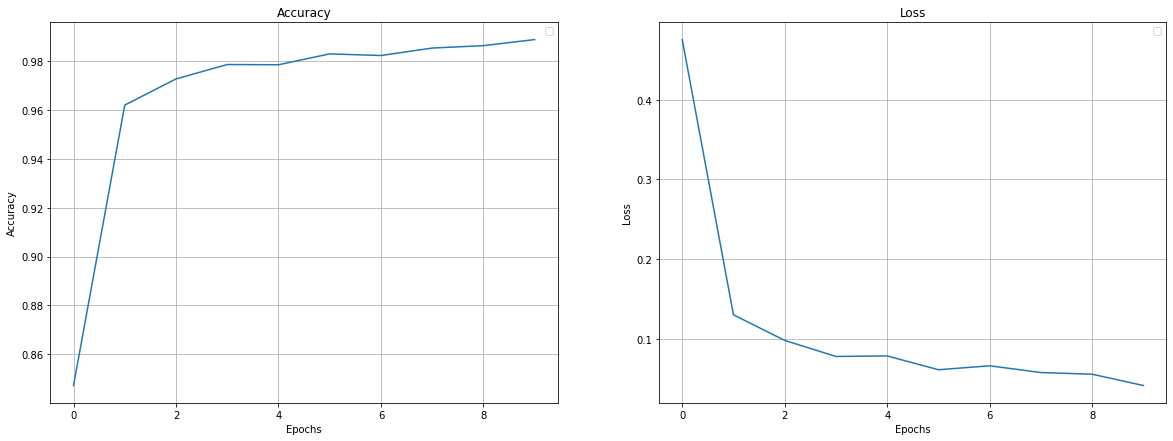

In [29]:
#History
plt.figure(figsize=(20,7))
plt.subplot(121)
plt.plot(Teacher_hist.history['sparse_categorical_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy")
plt.grid()
plt.legend()


plt.subplot(122)
plt.plot(Teacher_hist.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss")
plt.grid()
plt.legend()

plt.show()

## Knowledge Distillation

In [32]:
# Create the student
student = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(32, 32, 3)),
        tf.keras.layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10),
    ],
    name="student",
)

# Clone student for later comparison
student_scratch = tf.keras.models.clone_model(student)

In [33]:
dist = Distiller(teacher, student)
dist.compile(
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
    distillation_loss_fn = tf.keras.losses.KLDivergence(),
    student_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    alpha = 0.1,
    temperature = 20)



# Distill teacher to student
dist_hist = dist.fit(x_train, y_train, epochs=Epochs, batch_size = Batch)

# Evaluate student on test dataset
dist.evaluate(x_test, y_test)

Epoch 1/10
938/938 [==============================] - 17s 16ms/step - sparse_categorical_accuracy: 0.9291 - student_loss: 0.2634 - distillation_loss: 0.0075
Epoch 2/10
938/938 [==============================] - 15s 16ms/step - sparse_categorical_accuracy: 0.9740 - student_loss: 0.1156 - distillation_loss: 0.0074
Epoch 3/10
938/938 [==============================] - 15s 16ms/step - sparse_categorical_accuracy: 0.9781 - student_loss: 0.1018 - distillation_loss: 0.0072
Epoch 4/10
938/938 [==============================] - 15s 16ms/step - sparse_categorical_accuracy: 0.9807 - student_loss: 0.0939 - distillation_loss: 0.0071
Epoch 5/10
938/938 [==============================] - 15s 16ms/step - sparse_categorical_accuracy: 0.9827 - student_loss: 0.0872 - distillation_loss: 0.0070
Epoch 6/10
938/938 [==============================] - 15s 16ms/step - sparse_categorical_accuracy: 0.9838 - student_loss: 0.0832 - distillation_loss: 0.0069
Epoch 7/10
938/938 [==============================] - 15s 

[0.9811999797821045, 0.024568749591708183]

## Training from Scratch

In [34]:
# Training studen model from scratch
student_scratch.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
  )

scrratch_stud_hist = student_scratch.fit(x_train, y_train, epochs=Epochs, batch_size = Batch)

# Evaluate student on test dataset
student_scratch.evaluate(x_test, y_test)

Epoch 1/10
938/938 [==============================] - 5s 5ms/step - loss: 0.2521 - sparse_categorical_accuracy: 0.9254
Epoch 2/10
938/938 [==============================] - 8s 8ms/step - loss: 0.0971 - sparse_categorical_accuracy: 0.9705
Epoch 3/10
938/938 [==============================] - 7s 8ms/step - loss: 0.0718 - sparse_categorical_accuracy: 0.9778
Epoch 4/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0619 - sparse_categorical_accuracy: 0.9811
Epoch 5/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0568 - sparse_categorical_accuracy: 0.9827
Epoch 6/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0502 - sparse_categorical_accuracy: 0.9845
Epoch 7/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0477 - sparse_categorical_accuracy: 0.9854
Epoch 8/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0453 - sparse_categorical_accuracy: 0.9857
Epoch 9/10
938/938 [============================

[0.06361951678991318, 0.9805999994277954]

## Evaluating both performances

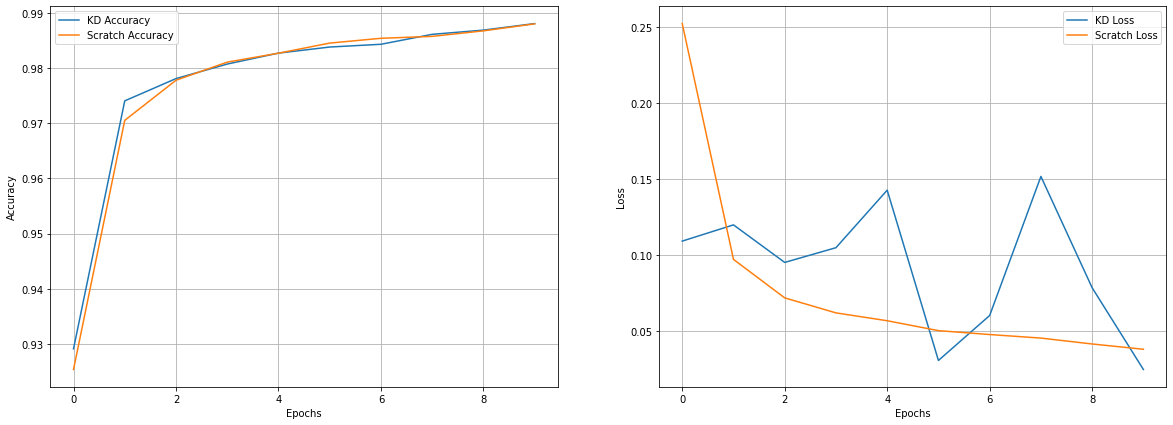

In [35]:
plot_hist(dist_hist.history['student_loss'], scrratch_stud_hist.history['loss'] ,dist_hist.history['sparse_categorical_accuracy'] , scrratch_stud_hist.history['sparse_categorical_accuracy'])